In [2]:
import os
import pandas as pd
import json
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import matplotlib as mpl
import matplotlvscode-remote://ssh-remote%2Bbalint-pc/media/balint/st3/projects/nanobio/nanobio/notebooks/mic-fitter.ipynbib
from collections import Counter

COLOR_PATH = '../../data/classification_datasets/color_map.csv'
DATA_PATH = '../../data/classification_datasets/total-results/'
# DATA_PATH = '../../data/classification_datasets/non-adjacent-results/'
# matplotlib.rcParams.update({'font.size': 12})

color_map = pd.read_csv(COLOR_PATH)
cm = list(color_map.iloc[:, 1])
cell_types = {color_map.iloc[i, 0]: color_map.iloc[i, -1] for i in range(len(color_map))}
color_map = {color_map.iloc[i, 0]: color_map.iloc[i, 1] for i in range(len(color_map))}

model_names = {
    'cnn': 'CNN',
    'cnn-lstm': 'CNN-LSTM',
    'resnet': 'ResNet',
    'densenet': 'DenseNet'
}

metric_names = {
    'acc': 'Accuracy',
    'pre': 'Precision',
    'rec': 'Recall',
    'f1': 'F1-score',
    'mse': 'Mean squared error',
    'cel': 'Cross Entropy Loss',
    'll': 'Logistic Loss',
    'auc': 'AUC score',
    'aucpr': 'Average precision score'
}

coating_names = lambda x: x.capitalize()

seg_styles = {
    'im_cover': 'solid',
    'im_pred': 'dashed',
    'im_watershed': 'dotted',
}

seg_names = {
    'im_cover': 'Manual',
    'im_pred': 'Generated',
    'im_watershed': 'Watershed',
}

stat_file_name = 'stats.csv'
COATING_TYPES = list(sorted([ct for ct in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, ct))]))
MEAS_PATH = lambda c: os.path.join(DATA_PATH, c, '3d-coating-evaluation/result')
NETWORKS = list(model_names.keys())
# MEAS_TYPES = list(set(['-'.join(ms.split('-')[:-2]) for ms in os.listdir(os.path.join(MEAS_PATH(COATING_TYPES[0]), NETWORKS[0]))]))
MEAS_TYPES = ['h838-hela-hepg2-lclc-mcf7-mdamb231', 'h838-hela-hepg2-lclc-mcf7-mdamb231-preo']
TIMES = list(sorted(set([int(ms.split('-')[-2]) for ms in os.listdir(os.path.join(MEAS_PATH(COATING_TYPES[0]), NETWORKS[0]))])))[:-1]
SEG_TYPES = list(sorted(set([ms.split('-')[-1] for ms in os.listdir(os.path.join(MEAS_PATH(COATING_TYPES[0]), NETWORKS[0]))])))
# MEAS_TYPES = [f for f in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, f))]

def format_cell_types(st):
    selected_types = sorted([cell_types[tp] for tp in st.split('-')])
    return ' | '.join(selected_types)

def group_indices_by_value(lst):
    index_list = [[] for _ in range(max(lst) + 1)]
    
    for i, item in enumerate(lst):
        index_list[item].append(i)
    
    return [indices for indices in index_list if indices]

def slice_list_with_indices(input_list, indices):
    return [input_list[i] for i in indices]

def list_cell_counts():
    cell_counts = {}
    for ct in COATING_TYPES:
        cell_counts[ct] = {}
        for tp in MEAS_TYPES:
            if os.path.exists(os.path.join(MEAS_PATH(ct), '..', f'{tp}-im_cover-cell_counts.json')):
                cell_counts[ct][tp] = {}
                types = tp.split('-')
                for sg in SEG_TYPES:
                    cell_counts[ct][tp][sg] = [0 for _ in range(len(TIMES))]
                    with open(os.path.join(MEAS_PATH(ct), '..', f'{tp}-{sg}-cell_counts.json'), 'r') as fp:
                        type_counts = json.load(fp)
                        for t in range(len(TIMES)):
                            for ctp in types: 
                                cell_counts[ct][tp][sg][t] += type_counts[ctp][t]
                    #     counts[n] = cnt[l]
                    #     types[cell_types[n]].append(str(cnt[l]))
                # cell_counts[format_cell_types(tp)] = { cell_types[t]: '|'.join(types[cell_types[t]]) for t in tp.split('-')}
    return cell_counts

def list_stats_dict(use_kfold=True):
    stats_dict = {}
    for ct in COATING_TYPES:
        file_path = os.path.join(MEAS_PATH(ct), NETWORKS[0], '-'.join([MEAS_TYPES[0], str(TIMES[0]), SEG_TYPES[0]]), stat_file_name)
        if os.path.exists(file_path):
            stats_dict[ct] = {}
            for tp in MEAS_TYPES:
                file_path = os.path.join(MEAS_PATH(ct), NETWORKS[0], '-'.join([tp, str(TIMES[0]), SEG_TYPES[0]]), stat_file_name)
                if os.path.exists(file_path):
                    if not tp in stats_dict[ct]:
                        stats_dict[ct][tp] = {}
                    ctps = tp.split('-')
                    d = { 'de_p': [], 'de_w': [], 'dl_p': [], 'dl_cp': [], 'dl_w': []}
                    for ctp in ctps:
                        file_path = os.path.join(MEAS_PATH(ct), f'../{ctp}/{ctp}_stats.json')
                        if os.path.exists(file_path):
                            with open(file_path, 'r') as fp:
                                data = json.load(fp)
                                d['de_p'] = np.concatenate([d['de_p'], data['de_p']])
                                d['de_w'] = np.concatenate([d['de_w'], data['de_w']])
                                if len(d['dl_p']) == 0:
                                    d['dl_p'] = data['dl_p']
                                    d['dl_cp'] = data['dl_cp']
                                    d['dl_w'] = data['dl_w']
                                else:
                                    d['dl_p'] = np.vstack([d['dl_p'], data['dl_p']])
                                    d['dl_cp'] = np.vstack([d['dl_cp'], data['dl_cp']])
                                    d['dl_w'] = np.vstack([d['dl_w'], data['dl_w']])
                    stats_dict[ct][tp]['de_p'] = np.round((np.mean(d['de_p']), np.std(d['de_p'])),2).tolist()
                    stats_dict[ct][tp]['de_w'] = np.round((np.mean(d['de_w']), np.std(d['de_w'])),2).tolist()
                    stats_dict[ct][tp]['dl_p'] = np.round(np.nanmean(d['dl_p'], axis=0),2).tolist()
                    stats_dict[ct][tp]['dl_cp'] = np.round(np.nanmean(d['dl_cp'], axis=0),2).tolist()
                    stats_dict[ct][tp]['dl_w'] = np.round(np.nanmean(d['dl_w'], axis=0),2).tolist()
                    for sgt in SEG_TYPES:
                        stats_dict[ct][tp][sgt] = {}
                        for nw in NETWORKS:
                            if not nw in stats_dict[ct][tp][sgt]:
                                stats_dict[ct][tp][sgt][nw] = {}
                            precision, accuracy, recall, f1, mse, cel, ll, auc, aucpr = [], [], [], [], [], [], [], [], []
                            for tm in TIMES:    
                                file_path = os.path.join(MEAS_PATH(ct), nw, '-'.join([tp, str(tm), sgt]), 'stats.csv' if not use_kfold else 'kfold_stats.csv')
                                if os.path.exists(file_path):
                                    df = pd.read_csv(file_path)
                                    df = df.iloc[0 if not use_kfold else -3:-1]
                                    precision.append(df.precision)
                                    accuracy.append(df.accuracy)
                                    recall.append(df.recall)
                                    f1.append(df.iloc[:, 3])
                                    mse.append(df.mse)
                                    cel.append(df.iloc[:, 5])
                                    ll.append(df.ll)
                                    auc.append(df.auc)
                                    aucpr.append(df.aucpr)

                            stats_dict[ct][tp][sgt][nw] = {
                                'pre': np.round(precision, 2).tolist(),
                                'acc': np.round(accuracy, 2).tolist(),
                                'rec': np.round(recall, 2).tolist(),
                                'f1': np.round(f1, 2).tolist(),
                                'mse': np.round(mse, 2).tolist(),
                                'cel': np.round(cel, 2).tolist(),
                                'll': np.round(ll, 2).tolist(),
                                'auc': np.round(auc, 2).tolist(),
                                'aucpr': np.round(aucpr, 2).tolist(),
                            }
    return stats_dict

def create_network_compare_plot(path, stats_dict, cell_counts, meas_selection, network_selection, metric_selection):
    ct_c = 0
    for ct in COATING_TYPES:
        if meas_selection in list(stats_dict[ct].keys()):
            # print(list(stats_dict[ct].keys()))
            ct_c+=1

    if ct_c == 1:
        fig, ax = plt.subplots(1, len(metric_selection), figsize=(len(metric_selection)*3, 4.5), sharex=True, sharey=True)
        # ax = [[a] for a in ax]
        ax = [ax]
    else:
        fig, ax = plt.subplots(ct_c, len(metric_selection), figsize=(len(metric_selection)*3, 8), sharex=True, sharey=True)
        plt.subplots_adjust(wspace=0.2, hspace=0.2)

    if len(metric_selection) == 1:
        ax = [ax]

    for l, mt in enumerate(metric_selection):
        for m, ct in enumerate(COATING_TYPES):
            for sg in SEG_TYPES:
                if meas_selection in list(stats_dict[ct].keys()):
                    for n, key in enumerate(sorted(list(model_names.keys()))):
                        if len(network_selection) > 0:
                            if key not in network_selection:
                                continue
                        metric = np.array(stats_dict[ct][meas_selection][sg][key][mt])
                        cnts = cell_counts[ct][meas_selection][sg]
                        indices = group_indices_by_value(cnts)
                        indices.reverse()
                        pos = 0
                        # ax[m][l].plot([.5*(pos+i+1) for i in range(len(slc))], slc, linestyle=seg_styles[sg], c=cm[n], label=model_names[key])
                        for i, lst in enumerate(indices):
                            slc, slc2 = np.array(slice_list_with_indices(metric[:,0], lst)), np.array(slice_list_with_indices(metric[:,1], lst))
                            ax[m][l].plot([.5*(pos+i+1) for i in range(len(slc))], slc, linestyle=seg_styles[sg], c=cm[n])
                            # ax[m][l].fill_between([.5*(pos+i+1) for i in range(len(slc))], slc - slc2, slc + slc2, color=cm[n], alpha=.2)
                            pos += len(slc)
                        ax[m][l].plot([.5*(i+1) for i in range(len(TIMES))], metric[:,0], c=cm[n], alpha=.2, linestyle=seg_styles[sg])
                        ax[m][l].plot([.5*(i+1) for i in range(len(TIMES))], metric[:,0], 'o', c=cm[n])
                        if m == 0:
                            ax[m][l].set_title(metric_names[mt],fontsize=12)
                            # ax[m][l].set_ylim((.3, 1))
                        # ax[m][l].set_ylim((0, 1))
                        # ax[m][l].set_yticklabels([str(round(i*0.2,1)) for i in range(5)])
                        ax[m][l].set_xticks([.5*(i+1) for i in range(len(TIMES))])
                        if m == len(ax) - 1:
                            ax[m][l].set_xlabel("Time(h)",fontsize=12)
                        # ax[m][l].legend()
                        if l == 0:
                            ax[m][l].set_ylabel(coating_names(ct),fontsize=12)
    handles = []
    for n, key in enumerate(sorted(list(model_names.keys()))):
        if len(network_selection) > 0:
            if key not in network_selection:
                continue
        obj, = ax[0][0].plot([], [], c=cm[n], label=model_names[key])
        handles.append(obj)

    for n, sg in enumerate(SEG_TYPES):
        obj, = ax[0][0].plot([], [], c='gray', label=seg_names[sg], linestyle=seg_styles[sg])
        handles.insert(2*n + 1,obj)

    plt.figlegend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, 0), ncol=4)
    plt.tight_layout(rect=[0,0.1 if ct_c > 1 else 0.15,1,1], w_pad=0.1)
    plt.savefig(os.path.join(path, f'{meas_selection}-comp.jpg'), pad_inches=5, dpi=500)
    plt.close()

def list_seg_stats(stats_dict, coating, meas_type):
    stats = {}
    seg_stats = ['de_p', 'dl_cp', 'dl_p', 'de_w', 'dl_w']
    for stat in seg_stats:
        stats[stat] = stats_dict[coating][meas_type][stat]
    return stats

def list_class_stats(stats_dict, coating, meas_type, metrics, time):
    stats = {}
    stats['metrics'] = metrics
    stats['seg'] = SEG_TYPES
    for nw in NETWORKS:
        stats[nw] = {}
        for mt in metrics:
            stats[nw][mt] = []
            for sgt in SEG_TYPES:
                stats[nw][mt].append(stats_dict[coating][meas_type][sgt][nw][mt][time])
    return stats


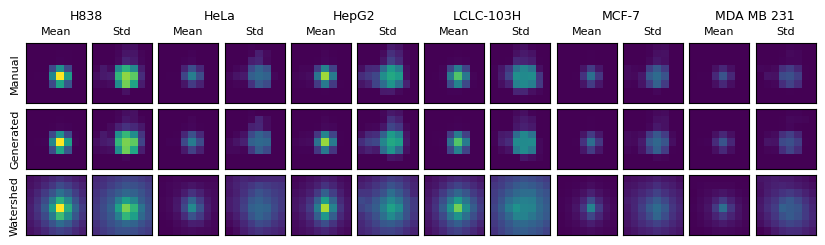

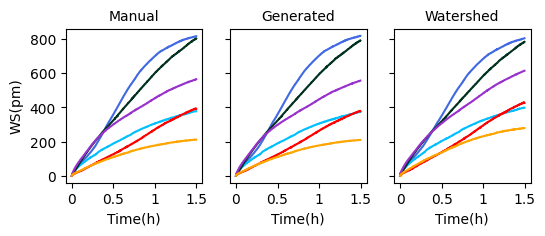

In [9]:
import tiffile as tif

coating_type = COATING_TYPES[1]
mstps = MEAS_TYPES[0]
ctps = mstps.split('-')

im_fig, im_ax = plt.subplots(len(list(seg_styles.keys())), len(ctps) * 2, figsize=(len(ctps) * 0.85 * 2,2.5), sharex=True, sharey=True)
sig_fig, sig_ax = plt.subplots(1, len(list(seg_styles.keys())), figsize=(6,2), sharex=True, sharey=True)
im_fig.subplots_adjust(wspace=0.1, hspace=0.1)
for j, stp in enumerate(list(seg_styles.keys())):
    cell_imgs = []
    cell_signals = []

    for i, ctp in enumerate(ctps):
        data_path = os.path.join(MEAS_PATH(coating_type), '..', ctp, stp)
        signals, imgs = [], []
        for file_name in sorted(os.listdir(data_path)):
            data = np.asarray(tif.imread(os.path.join(data_path, file_name)))[:600]
            if np.min(data) < -500:
                continue
            imgs.append(np.mean(data, axis=0))
            signals.append(np.max(data, axis=(1,2)))
        signals = np.asarray(signals)
        imgs = np.asarray(imgs)
        cell_signals.append(signals)
        cell_imgs.append(imgs)

    mx = np.max([np.max(np.mean(cell_imgs[i], axis=(0))) for i in range(len(ctps))])

    for i, ctp in enumerate(ctps):
        if j == 0:
            ax = im_fig.add_subplot(len(list(seg_styles.keys())), len(ctps), i + 1, frameon=False)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f"{cell_types[ctp]}\n", fontsize=9)
            im_ax[j, 2*i].set_title('Mean', fontsize=8)
            im_ax[j, 2*i + 1].set_title('Std', fontsize=8)
        if i == 0:
            im_ax[j, i].set_ylabel(seg_names[stp], fontsize=8)
        im = im_ax[j, 2*i].imshow(np.mean(cell_imgs[i], axis=(0)), vmin=0, vmax=mx)
        im_ax[j, 2*i + 1].imshow(np.std(cell_imgs[i], axis=(0)), vmin=0, vmax=mx)
        im_ax[j, 2*i].set_xticks([])
        im_ax[j, 2*i].set_yticks([])
        im_ax[j, 2*i + 1].set_xticks([])
        im_ax[j, 2*i + 1].set_yticks([])
    # ax = im_fig.add_subplot(1, len(ctps) + 1, len(ctps) + 1, frameon=False)
    for i, ctp in enumerate(ctps):
        sig_ax[j].set_title(seg_names[stp], fontsize=10)
        sig_ax[j].plot(np.mean(cell_signals[i], axis=0), label=cell_types[ctp], c=color_map[ctp])
        if j == 0:
            sig_ax[j].set_ylabel('WS(pm)')
        sig_ax[j].set_xticks([0, 200, 400, 600])
        sig_ax[j].set_xticklabels([0, 0.5, 1, 1.5])
        sig_ax[j].set_xlabel('Time(h)')
# im_fig.tight_layout()
im_fig.savefig(os.path.join(DATA_PATH, f'{coating_type}-{mstps}-spatial.png'), dpi=1000)
sig_fig.savefig(os.path.join(DATA_PATH, f'{coating_type}-{mstps}-temporal.png'), dpi=500)

In [3]:
stats_dict = list_stats_dict(use_kfold=True) 
with open(os.path.join(DATA_PATH, 'stats.json'), 'w') as fp:
    json.dump(stats_dict, fp, sort_keys=False, indent=4, separators=(',', ': '))

In [4]:
cell_counts = list_cell_counts()

with open(os.path.join(DATA_PATH, 'cell_counts.json'), 'w') as fp:
    json.dump(cell_counts, fp, sort_keys=False, indent=4, separators=(',', ': '))

In [5]:
create_network_compare_plot(DATA_PATH, stats_dict, cell_counts, 'h838-hela-hepg2-lclc-mcf7-mdamb231', ['densenet', 'cnn-lstm', 'resnet', 'cnn'], ['f1', 'acc', 'auc', 'aucpr'])
create_network_compare_plot(DATA_PATH, stats_dict, cell_counts, 'h838-hela-hepg2-lclc-mcf7-mdamb231-preo', ['densenet', 'cnn-lstm', 'resnet', 'cnn'], ['f1', 'acc', 'auc', 'aucpr'])

In [6]:
metric_selection = ['f1', 'auc', 'aucpr']
time = 1

export = {}
export[f'fibronectin - {format_cell_types("h838-hela-hepg2-lclc-mcf7-mdamb231")}'] = list_class_stats(stats_dict, 'fibronectin', 'h838-hela-hepg2-lclc-mcf7-mdamb231', metric_selection, time)
export[f'noncoated - {format_cell_types("h838-hela-hepg2-lclc-mcf7-mdamb231")}'] = list_class_stats(stats_dict, 'noncoated', 'h838-hela-hepg2-lclc-mcf7-mdamb231', metric_selection, time)
export[f'fibronectin - {format_cell_types("h838-hela-hepg2-lclc-mcf7-mdamb231-preo")}'] = list_class_stats(stats_dict, 'fibronectin', 'h838-hela-hepg2-lclc-mcf7-mdamb231-preo', metric_selection, time)

with open(os.path.join(DATA_PATH, 'class_stats.json'), 'w') as fp:
    json.dump(export, fp, sort_keys=False, indent=4, separators=(',', ': '))

In [7]:
export = {}
export[f'fibronectin - {format_cell_types("h838-hela-hepg2-lclc-mcf7-mdamb231")}'] = list_seg_stats(stats_dict, 'fibronectin', 'h838-hela-hepg2-lclc-mcf7-mdamb231')
export[f'noncoated - {format_cell_types("h838-hela-hepg2-lclc-mcf7-mdamb231")}'] = list_seg_stats(stats_dict, 'noncoated', 'h838-hela-hepg2-lclc-mcf7-mdamb231')
export[f'fibronectin - {format_cell_types("h838-hela-hepg2-lclc-mcf7-mdamb231-preo")}'] = list_seg_stats(stats_dict, 'fibronectin', 'h838-hela-hepg2-lclc-mcf7-mdamb231-preo')

with open(os.path.join(DATA_PATH, 'seg_stats.json'), 'w') as fp:
    json.dump(export, fp, sort_keys=False, indent=4, separators=(',', ': '))

In [8]:
from src.eval.eval import run_eval_multi
SRC_TEMPLATE = lambda x, result: f'../../data/classification_datasets/total-results/{x}/3d-coating-evaluation/{"result" if result else ""}'
base_args = {
    'color_path': '../../data/classification_datasets/',
    'normalize': 'std',
    'time': 60,
    'cell_types': 'h838-hela-hepg2-lclc-mcf7-mdamb231'.split('-'),
}

In [9]:
params_list = []
for ct in ['fibronectin', 'noncoated']:
    for tp in ['im_pred', 'im_watershed']:
        args = { 'path': SRC_TEMPLATE(ct, False),
                'result_path': SRC_TEMPLATE(ct, True),
                'seg_type': tp,
                'model_type': 'cnn-lstm' if ct == 'fibronectin' else 'resnet'
        }
        params_list.append(args)
        
run_eval_multi(DATA_PATH, params_list, **base_args)

Generated ../../data/classification_datasets/total-results/h838-hela-hepg2-lclc-mcf7-mdamb231-combo.jpg 4.34 s


In [10]:
base_args = {
    'color_path': '../../data/classification_datasets/',
    'normalize': 'std',
    'time': 60,
    'cell_types': 'h838-hela-hepg2-lclc-mcf7-mdamb231-preo'.split('-'),
}
params_list = []
for tp in ['im_pred', 'im_watershed']:
        args = { 'path': SRC_TEMPLATE('fibronectin', False),
                'result_path': SRC_TEMPLATE('fibronectin', True),
                'seg_type': tp,
                'model_type': 'cnn-lstm',
        }
        params_list.append(args)
        
run_eval_multi(DATA_PATH, params_list, **base_args)

Generated ../../data/classification_datasets/total-results/h838-hela-hepg2-lclc-mcf7-mdamb231-preo-combo.jpg 2.61 s
